<a href="https://colab.research.google.com/github/wangechi01-a/AirQo-African-Air-Quality/blob/main/Spot_mask_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install and import the Necessary Libraries

In [ ]:
!pip install -U albumentations
!pip install opencv-python==4.5.4.60
!pip install timm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.3/60.3 MB 2.7 MB/s eta 0:00:00
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.10.0.84
    Uninstalling opencv-python-4.10.0.84:
      Successfully uninstalled opencv-python-4.10.0.84
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 2.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata 

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
import os
import albumentations
from albumentations.pytorch import ToTensorV2
import pandas as pd
import numpy as np
import gc
import timm
import fastai
from fastai.vision.all import *
import random
import cv2
from PIL import Image
from pathlib import Path
from sklearn.preprocessing import LabelEncoder

In [ ]:
def random_seed(seed_value, use_cuda):
    np.random.seed(seed_value)
 #cpu vars
    torch.manual_seed(seed_value)
# cpu  vars
    random.seed(seed_value)
 # Python
    if use_cuda:
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
# gpu vars
        torch.backends.cudnn.deterministic = True
 #needed
        torch.backends.cudnn.benchmark = False
#Remember to use num_workers=0 when creating the DataBunch.

random_seed(2022,True)

In [ ]:
path = "/content/drive/MyDrive/Colab Notebooks/Mask Challenge/"
train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Mask Challenge/train_labels.csv")
ss = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Mask Challenge/SampleSubmission (5).csv")

In [ ]:
train.head()

,image,target
0,tfymlmdkpzkqdjhdxyhnoeuqszxphw.jpg,0
1,rxgismgsvmaayzjarbfjaljhqmpbrt.jpg,1
2,uuzshfrhkgrkolhwdvliqauzulurnz.jpg,0
3,mjspxsagzusaznvnyxgamtrlqkqklp.jpg,0
4,rlbmuajgezfiddjzlyeoupxpqubkpt.jpg,1


In [ ]:
train.image  = [path+"images/"+i for i in train.image]
train.image[0]

'/content/drive/MyDrive/Colab Notebooks/Mask Challenge/images//content/drive/MyDrive/Colab Notebooks/Mask Challenge/images//content/drive/MyDrive/Colab Notebooks/Mask Challenge/images/tfymlmdkpzkqdjhdxyhnoeuqszxphw.jpg'

In [ ]:
train.shape

(1308, 2)

In [ ]:
train.isnull().sum()

,0
image,0
target,0


Checking for missing values

In [ ]:
train.target.value_counts()

,count
target,
0,664
1,644


The dataset is not imbalanced

In [ ]:
#Rename the target

# Define the issues to be renamed
issues = [
    ('old_issue_name1', 'new_issue_name1'),
    ('old_issue_name2', 'new_issue_name2'),
]
for x,y in issues:
  train.loc[train['image'] == x, 'target'] = y

<ipython-input-28-d0d8937b018f>:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'new_issue_name1' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train.loc[train['image'] == x, 'target'] = y


In [ ]:
#Track rubbish labels
train.loc[train['target'] == ""].index.values.tolist()

[]

In [ ]:
#Drop them from the DataFrame.
train = train.drop(train.loc[train['target'] == ""].index.values.tolist(), axis = 0).reset_index(drop=True)
train.head()

,image,target
0,/content/drive/MyDrive/Colab Notebooks/Mask Challenge/images//content/drive/MyDrive/Colab Notebooks/Mask Challenge/images//content/drive/MyDrive/Colab Notebooks/Mask Challenge/images/tfymlmdkpzkqdjhdxyhnoeuqszxphw.jpg,0
1,/content/drive/MyDrive/Colab Notebooks/Mask Challenge/images//content/drive/MyDrive/Colab Notebooks/Mask Challenge/images//content/drive/MyDrive/Colab Notebooks/Mask Challenge/images/rxgismgsvmaayzjarbfjaljhqmpbrt.jpg,1
2,/content/drive/MyDrive/Colab Notebooks/Mask Challenge/images//content/drive/MyDrive/Colab Notebooks/Mask Challenge/images//content/drive/MyDrive/Colab Notebooks/Mask Challenge/images/uuzshfrhkgrkolhwdvliqauzulurnz.jpg,0
3,/content/drive/MyDrive/Colab Notebooks/Mask Challenge/images//content/drive/MyDrive/Colab Notebooks/Mask Challenge/images//content/drive/MyDrive/Colab Notebooks/Mask Challenge/images/mjspxsagzusaznvnyxgamtrlqkqklp.jpg,0
4,/content/drive/MyDrive/Colab Notebooks/Mask Challenge/images//content/drive/MyDrive/Colab Notebooks/Mask Challenge/images//content/drive/MyDrive/Colab Notebooks/Mask Challenge/images/rlbmuajgezfiddjzlyeoupxpqubkpt.jpg,1


In [ ]:
#Check new label distribution after editing
train.target.value_counts()

,count
target,
0,664
1,644


In [ ]:
#check the size of one image as it'll give you a sense of what you are about to resize
Image.open(path + 'images/tfymlmdkpzkqdjhdxyhnoeuqszxphw.jpg').size

(600, 411)

In [ ]:
Image.open(path + 'images/rxgismgsvmaayzjarbfjaljhqmpbrt.jpg').size

(800, 531)

<ipython-input-54-98a14744aeee>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train['target'])


<Axes: xlabel='target', ylabel='Density'>

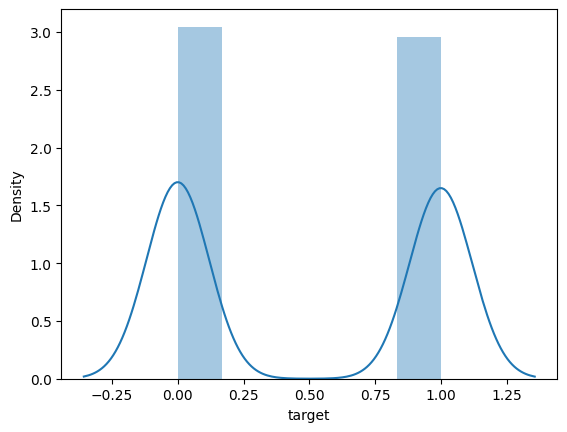

In [ ]:
import seaborn as sns
sns.distplot(train['target'])

In [ ]:
class AlbumentationsTransform (RandTransform):
    split_idx,order=None,2
    def __init__(self, train_aug, valid_aug): store_attr()

    def before_call(self, b, split_idx):
        self.idx = split_idx

    def encodes(self, img: PILImage):
        if self.idx == 0:
            aug_img = self.train_aug(image=np.array(img))['image']
        else:
            aug_img = self.valid_aug(image=np.array(img))['image']
        return PILImage.create(aug_img)

In [ ]:
def get_train_aug(): return albumentations.Compose([
            albumentations.RandomResizedCrop(384, 384), #Extra tip, use size that's suitable for the efficentNetwork you are using.
            albumentations.CenterCrop(384,384),

            albumentations.RandomRotate90(),
            albumentations.Rotate(limit=(-90, 90)),
            albumentations.Transpose(),
            albumentations.RandomGamma(),
            albumentations.Blur(),
            albumentations.HorizontalFlip(p=0.5),
            albumentations.VerticalFlip(p=0.5),
            albumentations.ShiftScaleRotate(p=0.5),
            albumentations.HueSaturationValue(
                hue_shift_limit=0.2,
                sat_shift_limit=0.2,
                val_shift_limit=0.2,
                p=0.5
            ),
            albumentations.RandomBrightnessContrast(
                brightness_limit=(-0.1,0.1),
                contrast_limit=(-0.1, 0.1),
                p=0.5
            ),
            ], p=1.)



def get_valid_aug(): return albumentations.Compose([
            albumentations.Resize(384, 384),
            ], p=1.0)

item_tfms = AlbumentationsTransform(get_train_aug(), get_valid_aug())
batch_tfms = [Normalize.from_stats(*imagenet_stats)]


In [ ]:
file_exists = os.path.exists(path + 'images/iavowbmvkaaadzalntnrfyuwjclcyq.jpg')
print(file_exists)

True


In [ ]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


def collate_fn(batch):
    return tuple(zip(*batch))

# Function to display a batch of images
def show_batch(dataloader, figsize=(12, 12)):
    batch = next(iter(dataloader))
    images, labels = batch
    fig, axs = plt.subplots(1, len(images), figsize=figsize)
    for i, img in enumerate(images):
        axs[i].imshow(img.permute(1, 2, 0))  # Assuming img is a tensor of shape (C, H, W)
        axs[i].set_title(f"Label: {labels[i]}")
        axs[i].axis('off')
    plt.show()

# Create indices for splitting dataset
indices = torch.randperm(len(train)).tolist()

# Access the DataFrame rows using .iloc
train_subset = train.iloc[indices]

# Create the DataLoader using the subset
train_data_loader = DataLoader(
    train_subset,  # Use the subset here
    batch_size=10,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

# Display a batch
show_batch(train_data_loader, figsize=(12, 12))

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


KeyError: Caught KeyError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pandas/core/indexes/base.py", line 3791, in get_loc
    return self._engine.get_loc(casted_key)
  File "index.pyx", line 152, in pandas._libs.index.IndexEngine.get_loc
  File "index.pyx", line 181, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 7080, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 7088, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 0

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/usr/local/lib/python3.10/dist-packages/pandas/core/frame.py", line 3893, in __getitem__
    indexer = self.columns.get_loc(key)
  File "/usr/local/lib/python3.10/dist-packages/pandas/core/indexes/base.py", line 3798, in get_loc
    raise KeyError(key) from err
KeyError: 0
